In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


#enable IPython to display matplolib graphs
%matplotlib inline

from sklearn import tree


In [2]:
from ML_classes.DTModel import DTModel


2022-03-28 09:27:03.827516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-28 09:27:03.827577: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
weather_data = pd.read_csv("./data/weather_hourly_darksky.csv")
weather_data["time"] = pd.to_datetime(weather_data["time"])
weather_data["temperature"] = pd.to_numeric(weather_data["temperature"], downcast="float", errors="coerce")



In [4]:
#type(weather_data["temperature"].iloc[0])
weather_data["temperature"].isna().sum() 


0

In [5]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")


#max_value_energy = df["energy(kWh/hh)"].max()
#df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
#df.sort_values('tstp', inplace=True)



In [6]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000153")
hh.pop("LCLid")

#making data hourly or not
hh = hh.set_index("tstp")
hh = hh.resample("H").sum()
hh = hh.reset_index()

#use of weather data
weather_data = weather_data.set_index("time")
weather_set = weather_data[str(hh["tstp"].min()):str(hh["tstp"].max())]
weather_set = weather_set.reset_index()
hh["temperature"] = weather_set["temperature"]
# weather data doesnt necessarily contain data for all dates
hh.dropna(axis=0,how='any',subset=["temperature"], inplace=True)

hh_max = hh['energy(kWh/hh)'].max()
hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)
hh['temperature'] = hh['temperature'].apply(lambda x: x / hh_max)

In [7]:
weather_set["temperature"]


hh.tail()

,tstp,energy(kWh/hh),temperature
19854,2014-02-27 18:00:00,0.085509,0.950238
19855,2014-02-27 19:00:00,0.216279,0.843513
19856,2014-02-27 20:00:00,0.164331,0.831940
19857,2014-02-27 21:00:00,0.115469,0.766362
19858,2014-02-27 22:00:00,0.162273,0.691783


In [8]:
# Initiating the class
DT = DTModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24,
epochs = 20,
batch_size = 256,
train_test_split = 0.15,
data_creator = "temperature"
)

In [9]:
DT.DTModel()

19859
19859


DecisionTreeRegressor()

In [10]:
yhat = DT.predict()
yhat

19859
19859


[0.45235951300195126,
 0.032017487359554696,
 0.031760316362460475,
 0.0325318216895228,
 0.054391147592527375,
 0.022245081440618358,
 0.025974023535410416,
 0.03523209129226848,
 0.027902789727148852,
 0.03883245459470622,
 0.12009771942233606,
 0.054005399719133915,
 0.02841712597317204,
 0.026745530778527822,
 0.04024687879225622,
 0.03446058788126124,
 0.03304615985160107,
 0.02571685637042636,
 0.1534010560191966,
 0.14452873996784216,
 0.03613218499196054,
 0.07509321837902108,
 0.07496462809033626,
 0.03908962367574535,
 0.15545839333906902,
 0.15545839333906902,
 0.0246881819623249,
 0.020830653410958192,
 0.025588271829906792,
 0.01915905630025889,
 0.16227335674211038,
 0.014915776043388562,
 0.11122540337098162,
 0.09862413756061479,
 0.09939564863584235,
 0.4024688109152232,
 0.042818565770537415,
 0.08769448418938791,
 0.04011829616779174,
 0.07753631890072762,
 0.04757618418948601,
 0.10453902259240475,
 0.02584544091094593,
 0.02584544091094593,
 0.08473703784138277,
 0

In [11]:
#type(DT.dc)

24
24
19859
19859


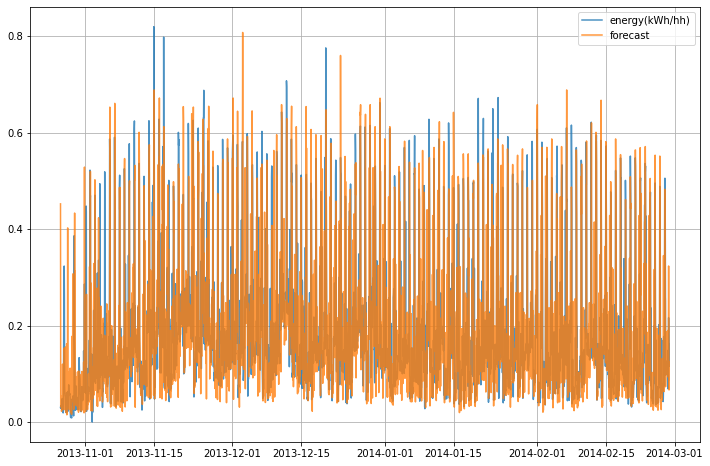

In [12]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
#X, _ = DT.dc.create_X_Y(ts, lag=lag_model)

#for time values
tlist = hh['temperature'].tail(lag_model).values.tolist()
#print(tlist)
X, _ = DT.dc.create_X_Y(ts, tlist, lag=lag_model)
#print(X)

X = DT.alter_x_shape(X)
# Getting the forecast
yhat = DT.model.predict(X)

yhat = DT.predict()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

In [13]:
#Forecasting n steps ahead, dont have weather data for n ahead however
n_ahead = 168 *2
yhat = DT.predict_n_ahead(n_ahead)
yhat = [y[0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(800).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

19859
24


ValueError: X has 19883 features, but DecisionTreeRegressor is expecting 48 features as input.

In [ ]:
DT.evaluateMSE()

In [ ]:
DT.evaluateRMSE()

In [ ]:
DT.evaluateMAE()

In [ ]:
DT.evaluateMAPE()

In [ ]:
DT.plot_dt()

In [14]:
#train for all houses
lclid_list = df['LCLid'].unique().tolist()
#print(type(lclid_list))
mse = []
rmse = []
mae = []
mape = []
for lclid in lclid_list:
    #print(lclid)


    hh = find_household(lclid)
    hh.pop("LCLid")
    hh = hh.set_index("tstp")
    hh = hh.resample("H").sum()
    hh = hh.reset_index()

    hh_max = hh['energy(kWh/hh)'].max()
    hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)
    
    # Initiating the class
    DT = DTModel(
    data = hh,
    Y_var = 'energy(kWh/hh)',
    lag = 24,
    epochs = 20,
    batch_size = 256,
    train_test_split = 0.15
    )
    #training
    DT.DTModel()
    
    mse.append(DT.evaluateMSE())
    rmse.append(DT.evaluateRMSE())
    mae.append(DT.evaluateMAE())
    mape.append(DT.evaluateMAPE())
houses = pd.Series(data=lclid_list,name="lclid")
mse = pd.Series(data=mse,name="mse")
rmse = pd.Series(data=rmse,name="rmse")
mae = pd.Series(data=mae,name="mae")
mape = pd.Series(data=mape,name="mape")

res_df = pd.merge(houses, mse, right_index=True, left_index=True)
res_df["rmse"] = rmse
res_df["mae"] = mae
res_df["mape"] = mape



In [15]:
res_df

,lclid,mse,rmse,mae,mape
0,MAC000168,0.010251,0.101249,0.039600,130.614049
1,MAC000169,0.012884,0.113506,0.065469,118.117797
2,MAC000179,0.009476,0.097345,0.053241,67.642755
3,MAC000181,0.005937,0.077052,0.037026,46.531289
4,MAC000165,0.012999,0.114013,0.069830,34.243529
5,MAC000173,0.016203,0.127291,0.078267,52.460872
6,MAC000152,0.015660,0.125141,0.069771,110.450884
7,MAC000153,0.011750,0.108396,0.072189,53.597817
8,MAC000159,0.008938,0.094539,0.056877,54.392321
9,MAC000150,0.013705,0.117067,0.066055,73.325034
